In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from collections import Counter, defaultdict

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [3]:
nS, nA = 750, 25
gamma = 0.99
tol = 1e-10

In [4]:
# mask out actions that clinicians never taken
Q_mask = np.load('action_mask.npy')

In [5]:
traj_te = pickle.load(open('trajDr_te.pkl', 'rb'))
# traj_te += pickle.load(open('trajD_va.pkl', 'rb'))
# traj_te = pickle.load(open('trajD_tr.pkl', 'rb'))

trajectories = traj_te

In [6]:
states_te = []
for traj in trajectories:
    for transition in traj:
        states_te.append(transition['s'])

In [7]:
len(states_te)

55315

## set-valued policy

In [8]:
Q_star = np.load('qlearn_Q.npy')
V_star = np.nanmax(Q_star, axis=1)
π_star = np.nanargmax(Q_star, axis=1)

In [9]:
def construct_SVP(Q_pi, Q_star, zeta):
    # Construct the SVP
    # Dictionary of {s: [a1, a2, ...]}
    pi_svp = {}
    for s in range(nS):
        Q_cutoff = min(V_star[s], (1-zeta) * V_star[s]) # lower bound for future return
        Pi_s = np.argwhere(
            np.where(Q_mask[s], Q_pi[s], -np.inf) > Q_cutoff
        )
        if len(Pi_s) > 0:
            assert not np.isnan(Q_pi[s][Pi_s]).all()
            pi_svp[s] = list(Pi_s.flatten())
        else:
            pi_svp[s] = [np.nanargmax(Q_pi[s])] # fall back to the greedy action

    # Tabular form, SxA, (s,a)=1 if a is included in π(s)
    PI_svp = np.zeros((nS, nA), dtype=int)
    for s, pi_s in pi_svp.items():
        for a in pi_s:
            PI_svp[s,a] = 1
    
    return pi_svp, PI_svp

In [10]:
zeta_range = [0.0,
              0.01, 0.02, 0.03, 0.04, 0.05,
              0.06, 0.07, 0.08, 0.09, 0.10,
             ]

In [11]:
# Near-greedy
πs_dict = {}
πs = {}
Qs = {}
for zeta in zeta_range:
    Q_pi = np.load('output_ql/svp_near-greedy_Q_gamma=0.99_zeta={}.npy'.format(zeta))
    pi_svp, PI_svp = construct_SVP(Q_pi, Q_star, zeta)
    πs_dict[zeta] = pi_svp
    πs[zeta] = PI_svp
    Qs[zeta] = Q_pi

## Group by V*

In [13]:
π = πs_dict[0.05]

In [17]:
c = pd.qcut(V_star, q=4)

In [18]:
state_categories = defaultdict(list)
for s, cat in enumerate(c.codes):
    state_categories[cat].append(s)

In [19]:
average_psizes = []
for cat in range(4):
    psize_ = np.mean([len(acts) for s, acts in π.items() if s in state_categories[cat]])
    average_psizes.append(psize_)

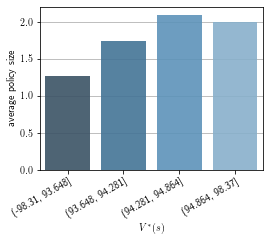

In [20]:
fig = plt.figure(figsize=(4,3))
ax = sns.barplot(list(c.categories), average_psizes, palette="Blues_d", alpha=0.9)
ax.set_axisbelow(True)
plt.grid(axis='y')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right', rotation_mode="anchor")
plt.xlabel('$V^*(s)$')
plt.ylabel('average policy size')
plt.savefig('fig/Vstar_psize.pdf', bbox_inches='tight')
plt.show()

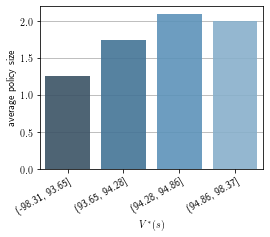

In [28]:
fig = plt.figure(figsize=(4,3))
ax = sns.barplot(['({:.2f}, {:.2f}]'.format(cat.left, cat.right) for cat in list(c.categories)], average_psizes, palette="Blues_d", alpha=0.9)
ax.set_axisbelow(True)
plt.grid(axis='y')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right', rotation_mode="anchor")
plt.xlabel('$V^*(s)$')
plt.ylabel('average policy size')
plt.savefig('fig/Vstar_psize.pdf', bbox_inches='tight')
plt.show()

In [7]:
states_te_died, states_te_surv = [], []
for traj in trajectories:
    r = traj[-1]['r']
    for transition in traj:
        if r == 100:
            states_te_surv.append(transition['s'])
        elif r == -100:
            states_te_died.append(transition['s'])
        else:
            assert False